#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 7: Classification with Logistic Regression, LDA/QDA, and Trees


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">


In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
# Note that this will take effect for all matplotlib plots, including those not made using seaborn:
# seaborn.set_theme(style='darkgrid')

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

<div class='exercise'><b> Question 1 [20 pts]: Overview of Multiclass Thyroid Classification </b></div>

In this problem set you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.

**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

In [106]:
# your code here
df = pd.read_csv('data/dataset_hw7.csv')
display(df.describe())
display(df.head())

,Biomarker 1,Biomarker 2,Diagnosis
count,215.000000,215.000000,215.000000
mean,0.414441,0.303155,1.441860
std,0.888106,2.174369,0.726737
min,-2.302485,-11.512925,1.000000
25%,0.000010,-0.510809,1.000000
50%,0.262372,0.693152,1.000000
75%,0.530634,1.410989,2.000000
max,4.032469,4.030695,3.000000


,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1
1,0.693152,0.262372,1
2,0.262372,0.405472,1
3,-0.105349,1.064714,1
4,0.000010,1.131405,1


In [5]:
def calculate_ratio(df):
    counts = df["Diagnosis"].value_counts()
    hyper_hypo_ratio = counts[2]/counts[3]
    return hyper_hypo_ratio


print(calculate_ratio(df))


1.1666666666666667


In [6]:
def count_table(df):
    counts = df["Diagnosis"].value_counts()
    df_counts = counts.to_frame().rename(index = {1:"normal", 2: "hyper", 3: "hypo"}).reset_index().rename(columns={"index": "disorders", "Diagnosis":"counts"})
    return df_counts

count_table(df)

,disorders,counts
0,normal,150
1,hyper,35
2,hypo,30


In [107]:
# your code here
class_names = {1: "1: normal", 2: "2: hyperthyroidism", 3: "3: hypothyroidism"}
def label_with_cls_names(df):
    return df.assign(Diagnosis=df.Diagnosis.replace(class_names))
# assign: Assign new columns to a DataFrame. Diagnosis is the new column name
# series.replace: Replace values given in to_replace (1st attribute) with value.
# !!!!!!!!!

class_counts = label_with_cls_names(df).Diagnosis.value_counts()
display(pd.DataFrame(
    {"Number of instances": class_counts,
     "%": class_counts / class_counts.sum()},
    ).rename_axis("Class"))
# rename_axis: Set the name of the axis for the index or columns. axis default is 0

def hyper_hypo_ratio(df):
    class_counts = df['Diagnosis'].value_counts()
    return class_counts[2] / class_counts[3]
overall_ratio = hyper_hypo_ratio(df)
print(f'Overall hyper-to-hypo ratio is {overall_ratio:.2f}')

,Number of instances,%
Class,,
1: normal,150,0.697674
2: hyperthyroidism,35,0.162791
3: hypothyroidism,30,0.139535


Overall hyper-to-hypo ratio is 1.17


**your answer here**

The dataset is highly imbalanced: almost 70% is in the "normal" class.

**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

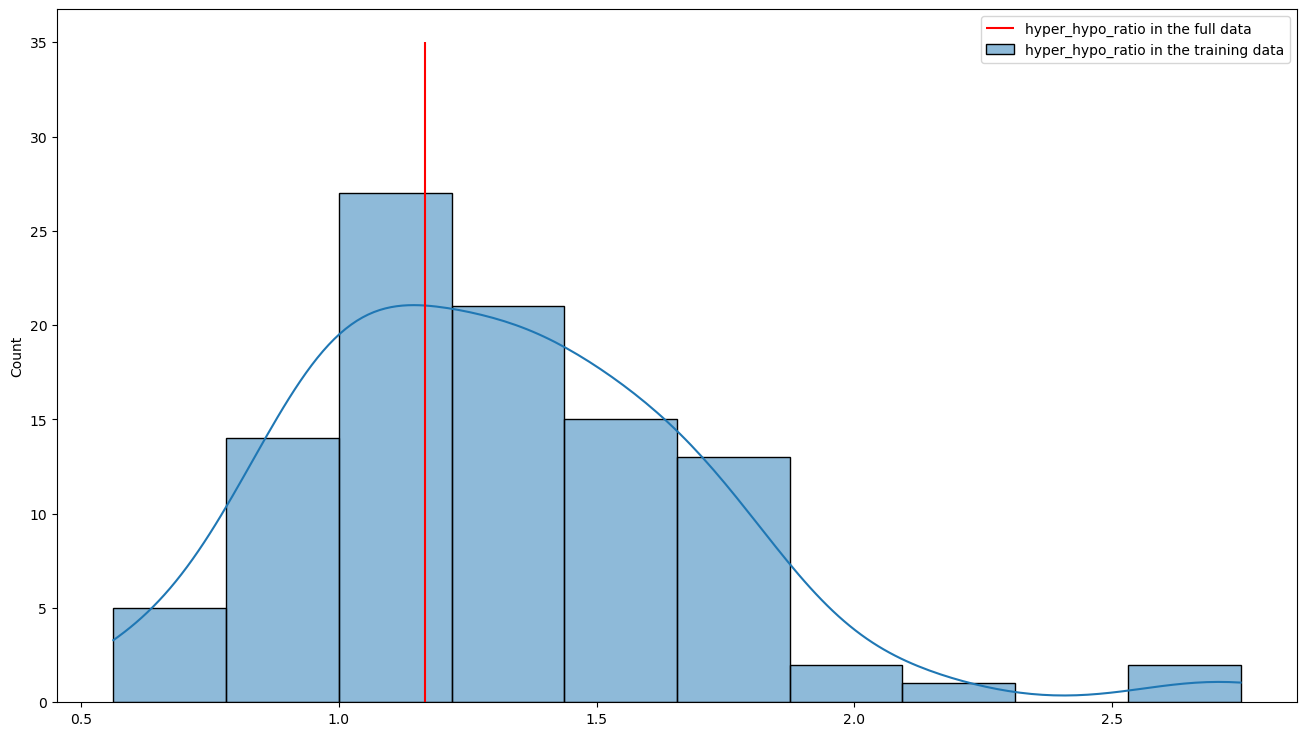

In [7]:
ratios = []
for _ in range(100):
    train,test = train_test_split(df, test_size=0.5)
    hyper_hypo_ratio = calculate_ratio(train)
    ratios.append(hyper_hypo_ratio)
plt.figure(figsize=(16,9))
sns.histplot(x = ratios, label  = "hyper_hypo_ratio in the training data", kde = True)
plt.vlines(calculate_ratio(df), 0, 35, label = "hyper_hypo_ratio in the full data", color = "red")    
plt.legend()

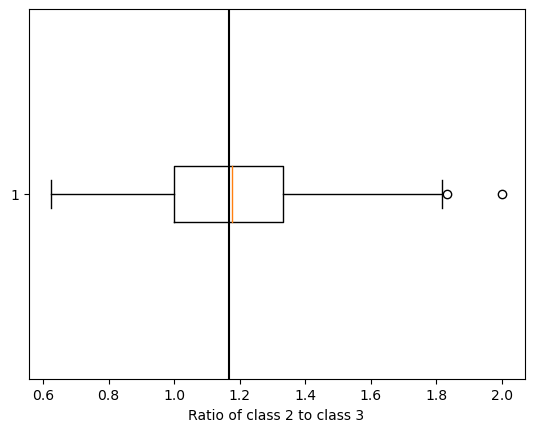

In [108]:
# your code here
ratios = []
for random_state in range(100):
    data_train, data_test = train_test_split(df, test_size=.5, random_state=random_state)
    ratios.append(hyper_hypo_ratio(data_train))
# plt.hist(ratios, normed=True);
plt.boxplot(ratios, vert=False)
# vert: If True, draws vertical boxes. If False, draw horizontal boxes. default is True

plt.axvline(overall_ratio, color='k')
plt.xlabel("Ratio of class 2 to class 3");

**your answer here**

Without stratification, many splits will not have a representative hyper-to-hypo ratio. For example, even though hyperthyroidism (class 2) seems to be more common, about 25% of possible train-test splits would have class 3 (hypothyroidism) as more common. And not only that, but we could easily get unlucky and have a ratio as low as 0.6 or as high as 2.0 (and these extreme ratios would lead to the opposite extremes in the test set since they have to average to 1.167). Note that our dataset is itself small, so we can't say what is the "right" ratio, but at least we'd want it to be similar between training and test.

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

In [109]:
data_train, data_test = train_test_split(df, test_size=.5, stratify=df.Diagnosis, random_state=99)

In [9]:
df_train = count_table(data_train)
df_test= count_table(data_test)

print(f"the hyper-hypo ratio for train data is {calculate_ratio(data_train)}.")
print(f"the hyper-hypo ratio for test data is {calculate_ratio(data_test)}.")

the hyper-hypo ratio for train data is 1.1333333333333333.
the hyper-hypo ratio for test data is 1.2.


In [110]:
# your code here
pd.DataFrame({
    'Instances in train': label_with_cls_names(data_train).Diagnosis.value_counts(),
    'Instances in test': label_with_cls_names(data_test).Diagnosis.value_counts()}).rename_axis("Class")

,Instances in train,Instances in test
Class,,
1: normal,75,75
2: hyperthyroidism,17,18
3: hypothyroidism,15,15


In [111]:
# your code here
print("Hyper-hypo ratio is {:.2f} in train, {:.2f} in test".format(
    hyper_hypo_ratio(data_train), hyper_hypo_ratio(data_test)))

Hyper-hypo ratio is 1.13 in train, 1.20 in test


**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

<Axes: xlabel='Biomarker 1', ylabel='Biomarker 2'>

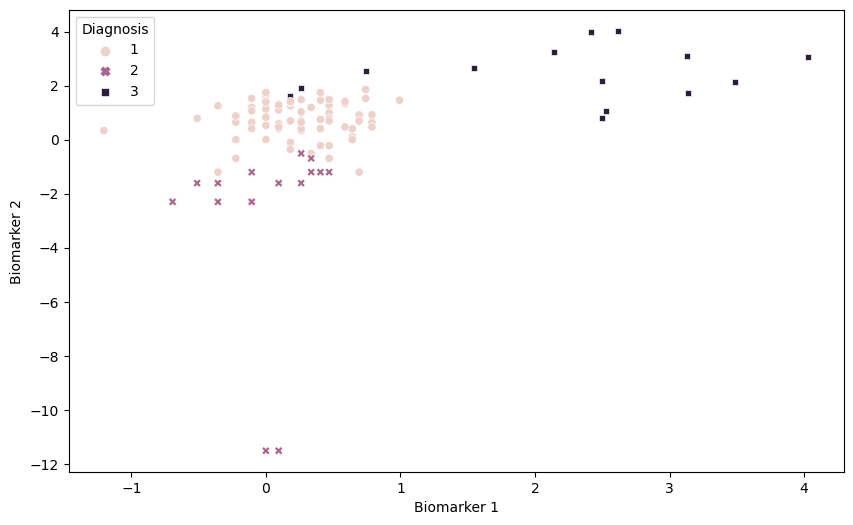

In [10]:
plt.figure(figsize =(10,6))
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis")

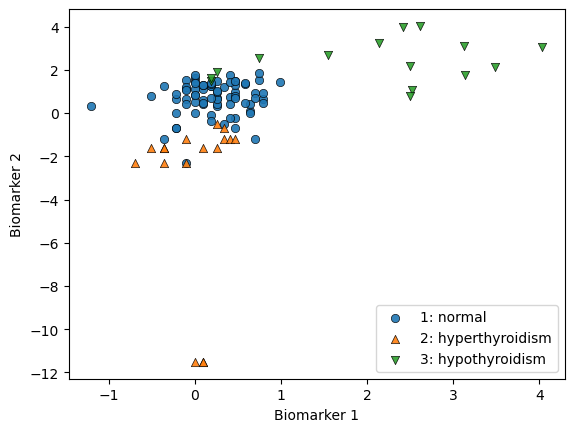

In [112]:
# your code here
X = data_train.iloc[:,:-1].values
y = data_train.iloc[:,-1].values

pal = sns.utils.get_color_cycle()
# Return the list of colors in the current matplotlib color cycle

class_colors = {1: pal[0], 2: pal[1], 3: pal[2]}
class_markers = {1: 'o', 2: '^', 3: 'v'}
# !!!!!!!!!!!
# iterate over every class

def plot_thyroid_data(ax, X, y):
    for response, class_name in class_names.items():
        subset = X[y == response]
        ax.scatter(
            subset[:, 0],
            subset[:, 1],
            label=class_name,
            alpha=.9, color=class_colors[response],
            lw=.5, edgecolor='k', marker=class_markers[response])
    ax.set(xlabel='Biomarker 1', ylabel='Biomarker 2')
    ax.legend(loc="lower right")

fig, ax = plt.subplots()
plot_thyroid_data(ax, X, y)

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

In [11]:
# use idxmax() or argmax() to find the largest value!!!


df_baseline = data_train.assign(baseline = data_train.Diagnosis.replace({2:1, 3:1}))
baseline_accuracy = accuracy_score(df_baseline["Diagnosis"], df_baseline["baseline"])
print(f"the baseline accuracy score is {baseline_accuracy}.")

the baseline accuracy score is 0.7009345794392523.


In [113]:
# your code here
most_likely_class = data_train.Diagnosis.value_counts().idxmax() # or: np.argmax(np.bincount(y))
baseline_accuracy = accuracy_score(y, np.array([most_likely_class] * len(y)))
print(f"The most likely class is {class_names[most_likely_class]}.")
print(f"Always predicting that class gets a training set accuracy of {baseline_accuracy:.2%}.")

The most likely class is 1: normal.
Always predicting that class gets a training set accuracy of 70.09%.


**your answer here**

This is a very high baseline accuracy, because the dataset is very imbalanced.

**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

In [12]:
def decision(df):
    hypo = 3 * (df[:,0] > 1.0)
    hyper = 2 * (np.logical_and(df[:,0]<=1.0, df[:,1]<0))
    normal = 1 * (np.logical_and(df[:,0]<=1.0, df[:,1]>=0))
    prediction = hypo+hyper+normal
    return prediction

raw_accuracy = accuracy_score(data_train.iloc[:,-1], decision(np.asarray(data_train.iloc[:,:-1])))
# np.array use array[:, -1], dataframe use df.iloc[:,-1]
# !!!!!!!!!!!!!!

print(f"the accuracy score is {raw_accuracy}.")

the accuracy score is 0.8598130841121495.


In [13]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]
    # np.c_ concat along columns, np.r_ concat along rows

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    # getattr(object, name, default)
    # Return the value of the named attribute of object. name must be a string. 
    # If the named attribute does not exist, default is returned if provided

    # X = stand.transform(X)
    y = model(X)
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        # Return whether an object is an instance of a class or of a subclass thereof.
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        # !!!!!!!
        # np.unique() Find the unique elements of an array.


        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."
        # !!!!!!!!!!!

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    # Decrease the saturation channel of a color by some percent.
    cmap = matplotlib.colors.ListedColormap(color_list)
    # Colormap object generated from a list of colors.

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, vmin=0, vmax=y.max() + 1)
    # zorder: Set the zorder for the artist. Artists with lower zorder values are drawn first.
    # vmin vmax: When using scalar data and no explicit norm, vmin and vmax define the data range that the colormap covers. 
    # By default, the colormap covers the complete value range of the supplied data. 
    
    # xx = xx.reshape(nx, ny)
    # yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
        # only contour, no filled colors
        # The colors of the levels, i.e. the lines for contour and the areas for contourf.
        # As a shortcut, single color strings may be used in place of one-element lists, i.e. 'red' instead of ['red'] to color all levels with the same color. 
        # try ax.contour(xx, yy, y, colors=["black", "red", "blue"], linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

        # norm=matplotlib.colors.NoNorm()

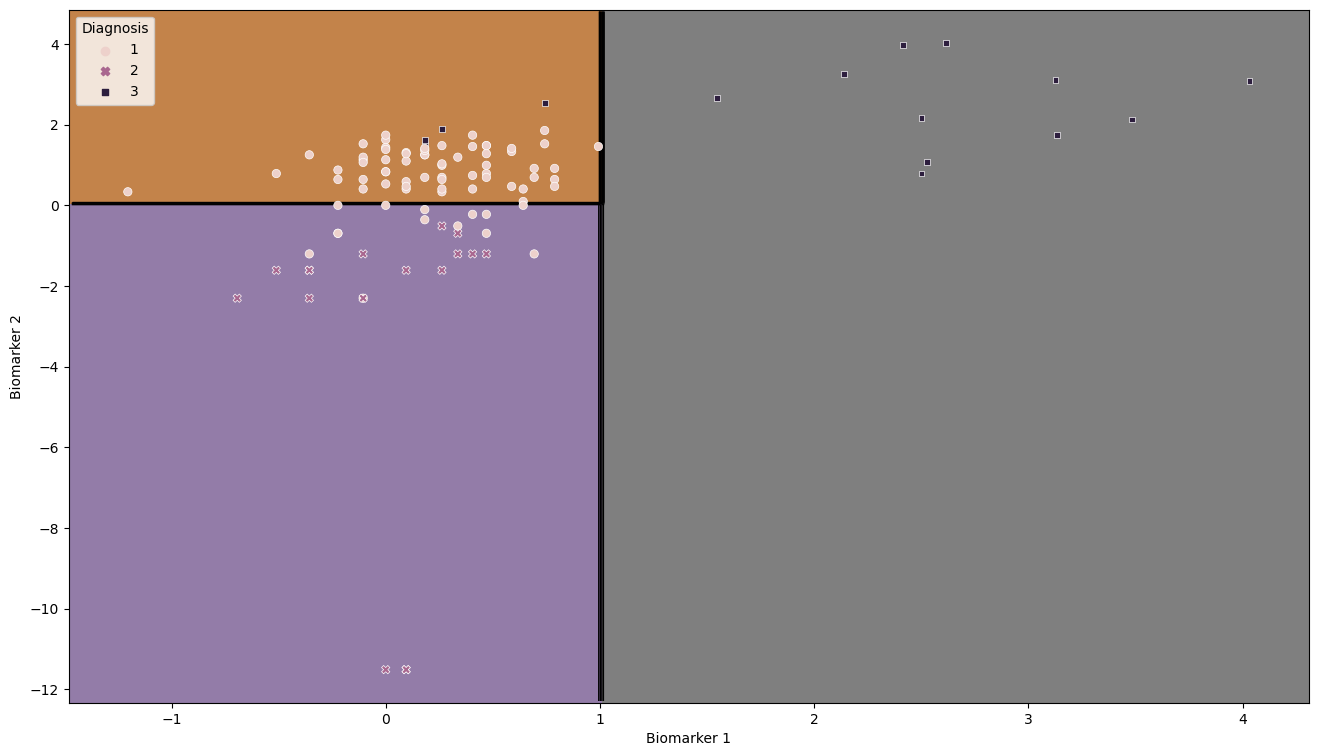

In [14]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis", ax = ax)
# need to plot this first, otherwise xmin = 0, xmax =1
overlay_decision_boundary(ax, decision)

In [66]:
# Update the following function:
def predict_manual_one_sample(x):
    return 0

In [114]:
# your code here:
def predict_manual_one_sample(x):
    if x[0] > 1.25:
        return 3
    elif x[1] < -1:
        return 2
    return 1

In [115]:
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in np.asarray(X)])
# np.asarray(Dataframe) iterate rows of the dataframe
# !!!!!!

manual_predictions = predict_manual(X)
accuracy = accuracy_score(y, manual_predictions)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 91.6%


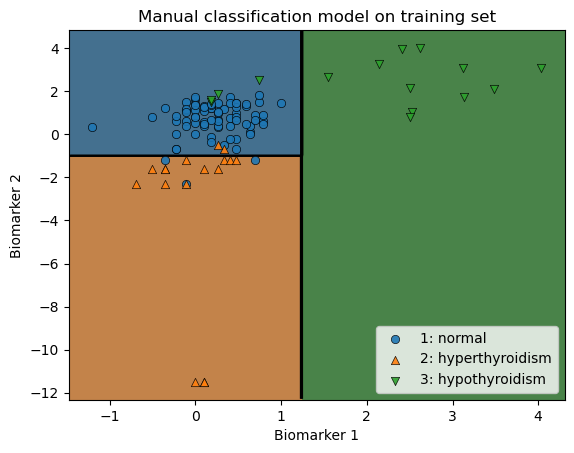

In [116]:
# Your code here
def plot_decision_boundary(x, y, model, title, ax):
    plot_thyroid_data(ax, x, y)
    overlay_decision_boundary(ax, model, colors=class_colors)
    ax.set_title(title)

fig, ax = plt.subplots()
xmin, xmax = ax.get_xlim()
# print(xmin)
# print(xmax)
plot_decision_boundary(X, y, predict_manual, 'Manual classification model on training set', ax)
ax.legend(loc='lower right');


In [16]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."
# check if all items are true
# !!!!!!!!!

Since an initial manual exploration of axis-aligned linear classifiers resulted an accuracy of over 85%, I'm quite confident that a tuned linear classifier could perform even better. However, the boundaries between normal and hyperthyroidism and normal and hypothyroidism seem to be slightly curved, so a classifier that permits curved decision boundaries might do even better. But with so little data, such a classifier would also be at greater risk of overfitting.

<div class='exercise'><b> Question 2 [20 pts]: Multiclass Logistic Regression</b></div>

**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

*Hint*: You should use `LogisticRegressionCV`. For the model with quadratic and interaction terms, you can use a Pipeline, like this:

In [15]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr"))

# Since this is a Pipeline, you can call `.fit` and `.predict` just as if it were any other estimator.
#
# Note that you can access the logistic regression classifier itself by
# polynomial_logreg_estimator.named_steps['logisticregressioncv']

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


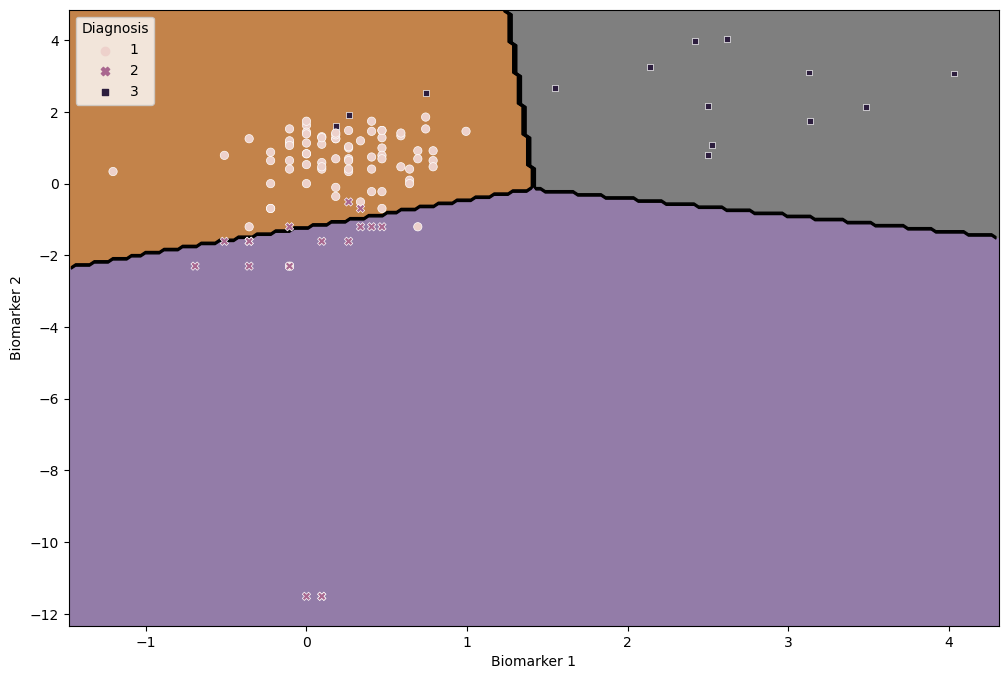

In [133]:
polynomial_logreg_estimator = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=1, include_bias=False),
    LogisticRegressionCV(multi_class="ovr", penalty="l2", solver="lbfgs", cv =5))


train_x = data_train.iloc[:,:-1]
test_x = data_test.iloc[:,:-1]
train_y = data_train.iloc[:, -1]
test_y = data_test.iloc[:,-1]

polynomial_logreg_estimator.fit(train_x, train_y)
fig= plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis", ax = ax)
overlay_decision_boundary(ax, polynomial_logreg_estimator)

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


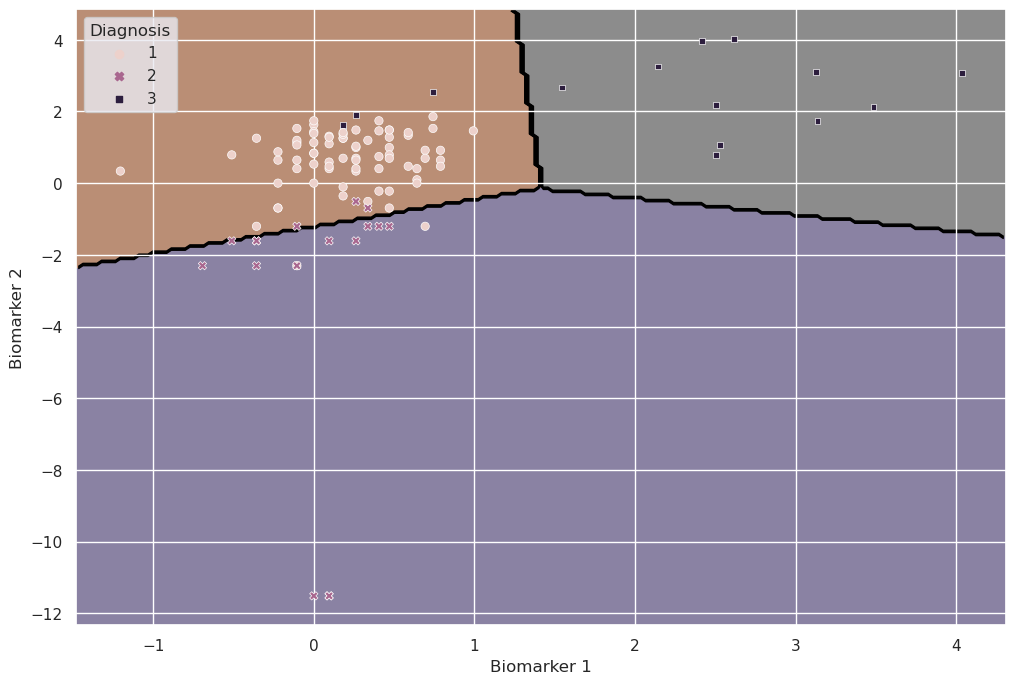

In [114]:
# standardize without popeline:

stand = StandardScaler()
train_x_stand = stand.fit_transform(train_x)
log = LogisticRegressionCV(multi_class="ovr",penalty="l2", solver="lbfgs", cv =5).fit(train_x_stand, train_y)
fig= plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis", ax = ax)
overlay_decision_boundary(ax, log)

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


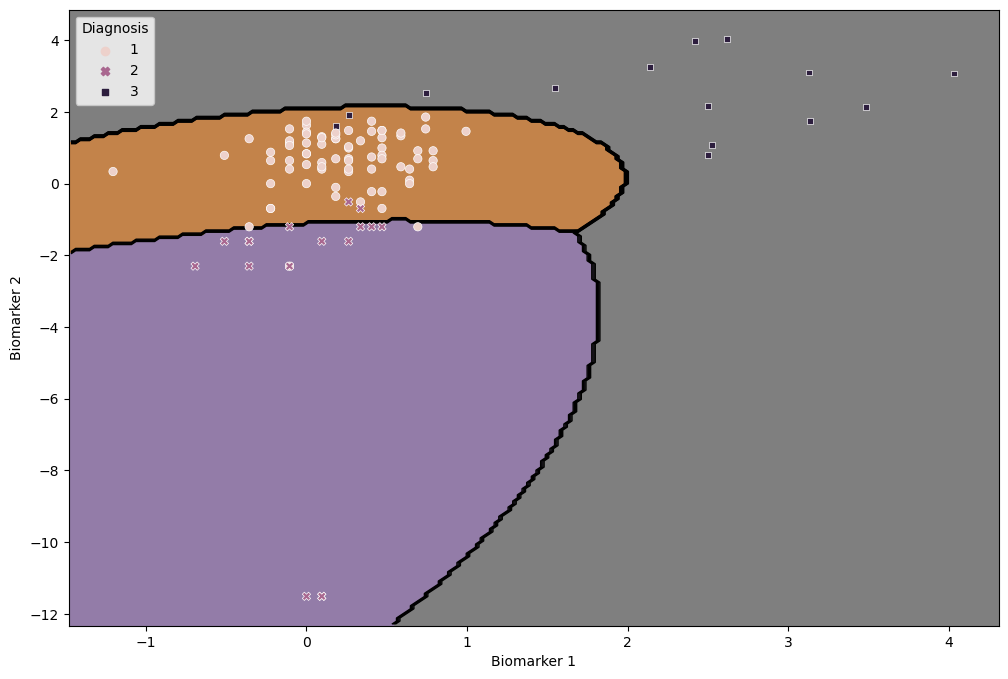

In [17]:
polynomial_logreg_estimator2 = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr", penalty="l2", solver="lbfgs", cv =5))


polynomial_logreg_estimator2.fit(train_x, train_y)
fig= plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis", ax = ax)
overlay_decision_boundary(ax, polynomial_logreg_estimator2)

In [18]:
# your code here
# Note that PolynomialFeatures makes both quadratic and interaction terms.
print("PolynomialFeatures generates the following terms:")
print(', '.join(PolynomialFeatures(degree=2, include_bias=False).fit(X).get_feature_names()))

PolynomialFeatures generates the following terms:
x0, x1, x0^2, x0 x1, x1^2


**Should we standardize?**

Since we're doing logistic regression with an L2 penalty, the scales of our coefficients matter. So we may want to consider standardizing. One major caution with standardization is that it changes the units of the predictors, so we need to be careful when plotting the data. We could, for example, label the axes as "Biomarker 1, Standardized" or something. Or we could take advantage of sklearn's pipelines to make all the scaling happen inside of the model-fitting process.

There's only one other approach we try this hw that we'd need to standardize for. Can you think of which one it is?

For simplicity, these solutions do not standardize. The difference in accuracy and decision boundaries is very small. However, notice how easy it is to standardize, using Pipelines!

In [118]:
# your code here
standardize_before_logreg = False
if not standardize_before_logreg:
    # without standardizing...
    logreg_ovr = LogisticRegressionCV(multi_class="ovr", cv=5).fit(X, y)
    polynomial_logreg_estimator = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        LogisticRegressionCV(multi_class="ovr", cv=5)).fit(X, y);

else:
    # with standardizing... since we want to standardize all features, it's really this easy:
    logreg_ovr = make_pipeline(
        StandardScaler(),
        LogisticRegressionCV(multi_class="ovr", cv=5)).fit(X, y)
    polynomial_logreg_estimator = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        LogisticRegressionCV(multi_class="ovr", cv=5)).fit(X, y);

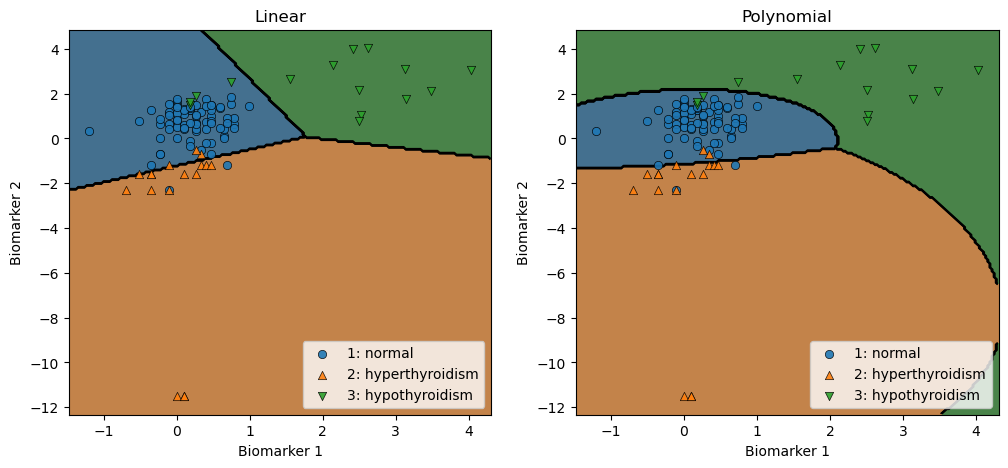

In [119]:
# your code here
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
named_classifiers = [
    ("Linear", logreg_ovr),
    ("Polynomial", polynomial_logreg_estimator)
]
for ax, (name, clf) in zip(axs, named_classifiers):
    plot_decision_boundary(X, y, clf, name, ax)

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?

**Your answer here**

* The decision boundaries do generally surround the corresponding training samples.
* At a decision boundary, two classes give the same probability. If the probabilities are based on linear combinations of the classifier's features, the curves of equal probability must be composed of lines. With polynomial and interaction features, the curves of equal probability are still composed of lines in the high-dimensional space, but they can project to curves in the original feature space.
* For Biomarker 2 less than -3, the linear classifier assigns all such points to hyperthyroidism, but the polynomial classifier has a complex decision rule that may or may not make sense. You could argue that it doesn't make sense to make a different decision at different points there because there's no data to justify that choice. Or you could argue that the polynomial classifier draws a boundary that correctly encloses all of the hyperthyroidism samples (but then why give a big region to hypothyroidism)?

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

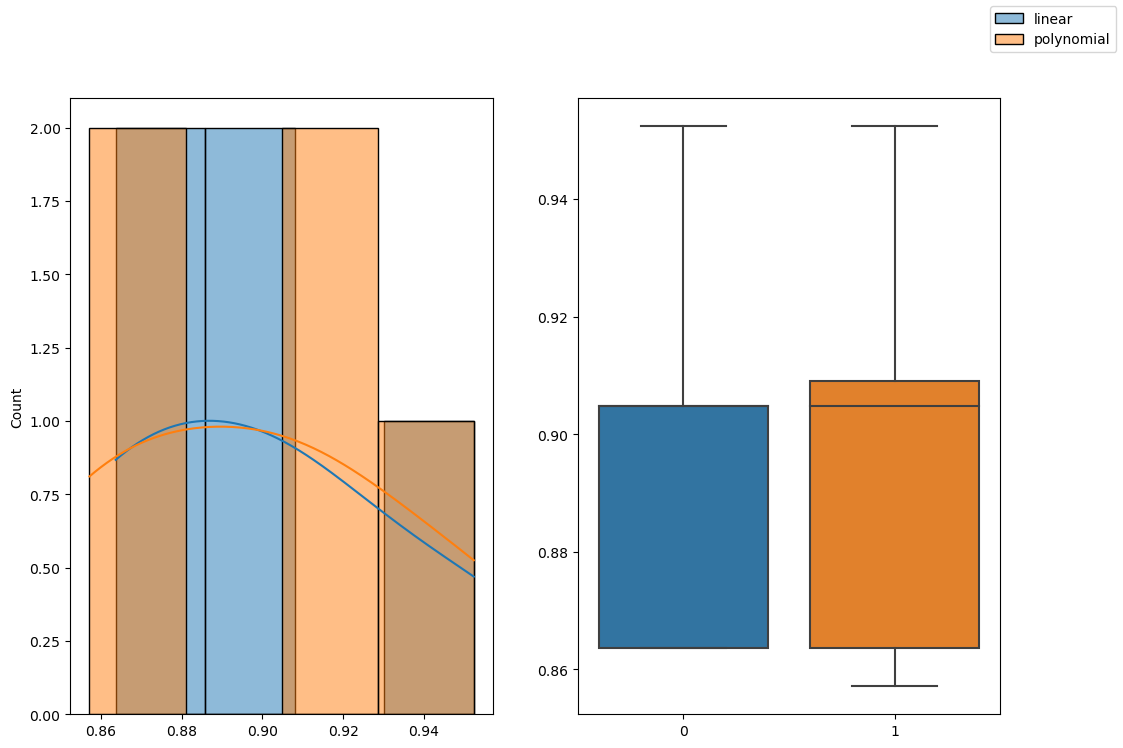

In [18]:
cv1 = cross_val_score(polynomial_logreg_estimator, train_x, train_y, cv = 5)
cv2 = cross_val_score(polynomial_logreg_estimator2, train_x, train_y, cv = 5)
cv = np.vstack((cv1,cv2)).T
cv1_mean = np.mean(cv1)
cv1_std = np.std(cv1)
cv2_mean = np.mean(cv2)
cv2_std = np.std(cv2)

fig, axes = plt.subplots(1,2,figsize = (12,8))


sns.histplot(x = cv1, label = "linear", alpha=0.5, kde =True, ax = axes[0])
sns.histplot(x = cv2, label = "polynomial", alpha=0.5, kde = True, ax = axes[0])

sns.boxplot(data = cv, ax = axes[1])
# !!!!!!!!!!!!!
# boxplot plot column data

fig.legend()

In [19]:
from prettytable import PrettyTable

table = PrettyTable(["model", "mean", "std"])

table.add_row(["linear", cv1_mean, cv1_std])
table.add_row(["polynomial", cv2_mean, cv2_std])

print(table)

+------------+--------------------+---------------------+
|   model    |        mean        |         std         |
+------------+--------------------+---------------------+
|   linear   | 0.8978354978354979 | 0.03289473634894002 |
| polynomial | 0.8974025974025974 | 0.03456703857606428 |
+------------+--------------------+---------------------+


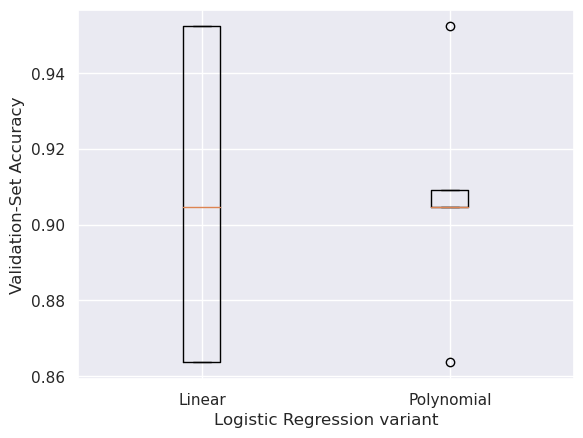

In [145]:
# your code here
cv_scores = [
    cross_val_score(model, X, y, cv=5)
    for name, model in named_classifiers]

plt.boxplot(cv_scores);
plt.xticks(np.arange(1, 3), [name for name, model in named_classifiers])
# !!!!!!!!!!!!
plt.xlabel("Logistic Regression variant")
plt.ylabel("Validation-Set Accuracy");

In [22]:
# your code here
print("Cross-validation accuracy:")
pd.DataFrame(cv_scores, index=[name for name, model in named_classifiers]).T.aggregate(['mean', 'std']).T

Cross-validation accuracy:


,mean,std
Linear,0.916883,0.048607
Polynomial,0.906926,0.031441


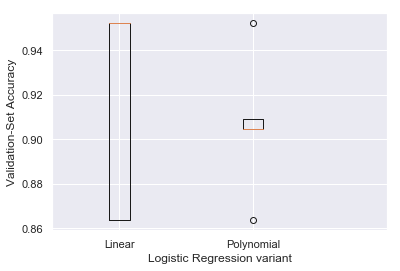

In [23]:
# your code here
cv_scores = [
    cross_val_score(model, X, y, cv=5)
    for name, model in named_classifiers]

plt.boxplot(cv_scores);
plt.xticks(np.arange(1, 4), [name for name, model in named_classifiers])
plt.xlabel("Logistic Regression variant")
plt.ylabel("Validation-Set Accuracy");

In [24]:
# your code here
print("Cross-validation accuracy:")
pd.DataFrame(cv_scores, index=[name for name, model in named_classifiers]).T.aggregate(['mean', 'std']).T

Cross-validation accuracy:


,mean,std
Linear,0.916883,0.048607
Polynomial,0.906926,0.031441


**Your answer here**

The linear classifier performs better on this sample, but the variance in the CV estimates is too high to have any confidence about which will generalize better.

The polynomial classifier has lower bias -- it is able to model more complex decision boundaries -- but higher variance. Regularizing the parameters helps, but the regularization applies to both the linear and polynomial terms, so no value of `C` can reduce the variance of the polynomial classifier to as low as the linear classifier. So the polynomial classifier is forced to overfit, even at the optimal C. (Though we may not have found the optimal C here; `LogisticRegressionCV` only tries a small number of values.)

One thing we could try is adding only the interaction term, not the quadratic (or vice versa). Or fitting an ensemble (see next homework!).

The polynomial classifier surprisingly seems to have lower validation variance than the linear. I'm not sure why that happens.

Note that we're actually running a nested CV here: For each training fold, `cross_val_score` calls `LogisticRegressionCV().fit()`, and `LogisticRegressionCV` then runs a CV within those samples to pick its best `C` parameters (then re-fits on the entire fold). That's a bit odd, but okay: we're treating the entire `LogisticRegressionCV` process as the learning process that we're evaluating.

!!!!!!!!!!! LogisticRegressionCV predict, score functions uses best C parameters

<div class='exercise'><b> Question 3 [20 pts]: Discriminant Analysis</b></div>

**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.

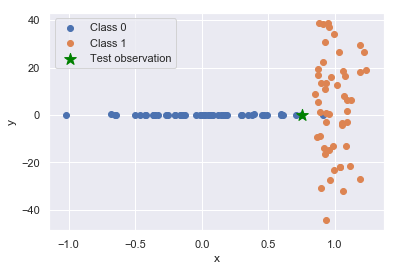

In [25]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.xlabel("x"); plt.ylabel("y")
plt.legend();

In [26]:
# your code here
np.cov(X_blobs.T)

array([[  0.33906979,   0.89650992],
       [  0.89650992, 224.13509768]])

In [27]:
# your code here
# True probabilies of test point under both classes
import scipy.stats
print(
    "Class 0 true probability:",
    scipy.stats.multivariate_normal(mean=[0., 0.,], cov=[[.4**2, 0.], [0., .1**2]]).pdf([.75, 0.]))
print(
    "Class 1 true probability:",
    scipy.stats.multivariate_normal(mean=[1., 0.,], cov=[[.1**2, 0.], [0., 20.**2]]).pdf([.75, 0.]))

Class 0 true probability: 0.6860438434655602
Class 1 true probability: 0.0034963900852328952


**Your answer here**

The test observation should belong to class 0 because (1) its nearest neighbors are class 0 and (2) it, like the rest of class 0, is very close to the y=0 line. (For next year we should put it at .65 so it's even clearer.)

Since we actually know the data generation process, we can evaluate the true probabilities: it's *much* more likely to be class 0. (We wouldn't expect the code above, we're just showing it for clarity.)

The data generation process here exactly fits the model of QDA: each blob has a separate mean (`centers`) and variance (specified by standard deviation, the square root of the variance, `cluster_std`). But as the figure shows, the variances are highly unequal: class 1 has a much higher variance in y than class 0, and vice versa. So the assumption from LDA that the variances are equal is very untrue here. In particular, since the covariance between x and y is small (though non-zero in our sample), the decision boundary will be approximately vertical, *halfway between the cluster centers* (x=0 and x=1) -- so the boundary will be at about x=.5. Since our test point is to the right of that line, LDA will classify the point as class 1. However, QDA will probably be able to make a reasonable approximation of the true class covariances from the sample we gave, so it will probably correctly classify the point as class 0. (It's possible, but unlikely, that the estimated covariance matrix would be sufficiently incorrect to make the classification come out the other way.) Well, let's just try it:

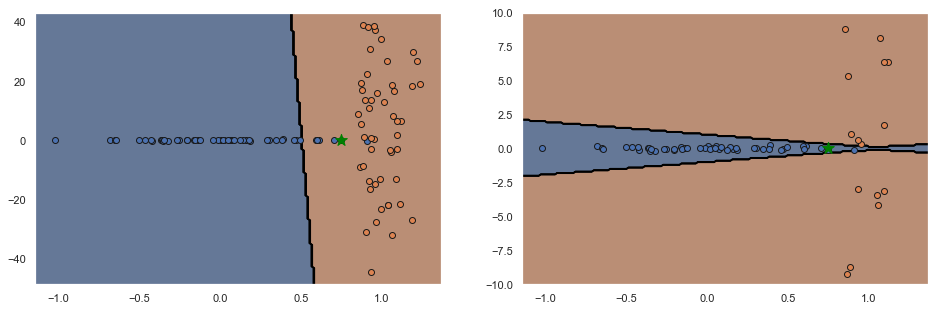

In [28]:
# Your code here
lda = LinearDiscriminantAnalysis().fit(X_blobs, y_blobs)
qda = QuadraticDiscriminantAnalysis().fit(X_blobs, y_blobs)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
for ax, model in zip(axs, (lda, qda)):
    for cls in range(2):
        ax.scatter(X_blobs[y_blobs==cls,0], X_blobs[y_blobs==cls,1], edgecolor='k')
    plt.ylim([-10, 10]) # zoom in so we can see
    overlay_decision_boundary(ax, model)
    
for ax in axs:
    ax.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

In [29]:
# Your code here
label_with_cls_names(data_train).groupby("Diagnosis").var()

,Biomarker 1,Biomarker 2
Diagnosis,,
1: normal,0.134103,0.607021
2: hyperthyroidism,0.120058,15.734945
3: hypothyroidism,1.537893,0.963413


In [30]:
# your code here
# Alternative approach that uses the NumPy arrays
pd.DataFrame(
    [
        np.var(X[y==idx], axis=0)
        for idx, class_name in sorted(class_names.items())
     ],
    index=[class_name for idx, class_name in sorted(class_names.items())],
    columns=['Biomarker 1', 'Biomarker 2'])

,Biomarker 1,Biomarker 2
1: normal,0.132315,0.598927
2: hyperthyroidism,0.112996,14.809360
3: hypothyroidism,1.435367,0.899186


In [31]:
# your code here
# Alternatively, we could have looked at all the covariance matrices,
# but we didn't ask that because it's harder to show.
# Notice that the diagonal elements are close to the marginal variances but not exactly the same.
# Can you explain why?
np.array([
    np.cov(X[y==idx].T) for idx, class_name in sorted(class_names.items())])

array([[[ 1.34102641e-01,  3.92526148e-02],
        [ 3.92526148e-02,  6.07021012e-01]],

       [[ 1.20058210e-01, -1.56209442e-02],
        [-1.56209442e-02,  1.57349448e+01]],

       [[ 1.53789301e+00,  3.46039693e-01],
        [ 3.46039693e-01,  9.63413407e-01]]])

**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

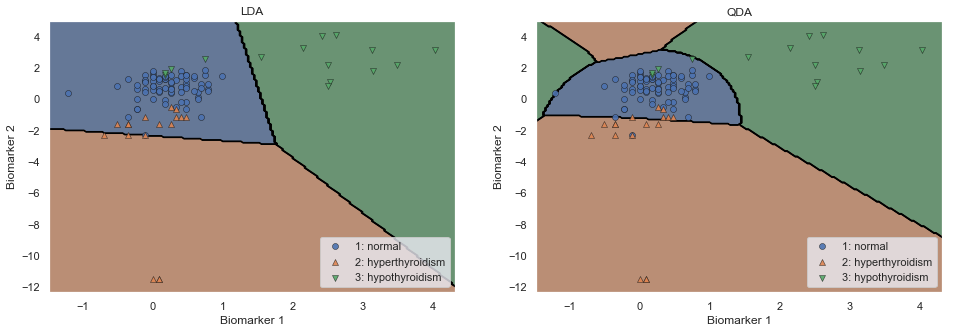

In [32]:
# your code here
lda = LinearDiscriminantAnalysis().fit(X, y)
qda = QuadraticDiscriminantAnalysis().fit(X, y)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
plot_decision_boundary(X, y, lda, 'LDA', axs[0])
plot_decision_boundary(X, y, qda, 'QDA', axs[1])

**Your answer here**

We notice various differences between the decision boundaries:
- The LDA boundaries have straight lines, vs QDA's are curved. You can think of QDA as squeezing in the space belonging to each class until its distribution looks Standard Normal / its ellipses actually become unit circles. Then it just picks out which class center the squeezed-in sample is closest to. For LDA, each class is squeezed in the same way, so the decision boundary is a scaled/rotated Voronoi diagram: which cluster center is closest? For QDA, each class gets squeezed independently, so the boundaries of which-is-closest can have interesting shapes.
- QDA makes extra regions where there isn't any data. Notice the extra *hyper* region above Normal, and the extra *hypo* region to the left of Normal. This is because the Normal region has lower variance overall, so its distribution is more "tight" than the other two. LDA doesn't do that. In this aspect, LDA seems to make more sense, though we'd need to know more biology to really decide.
- LDA gives too big of a region to Normal, because it has to let it have the same (high) variance as the other two classes. In particular, we notice the lower edge of the Normal region is pushed down from where it should be, so some `hyperthyroid` observations get misclassified. QDA's boundary seems to make more sense there.

<div class='exercise'> <b> Question 4 [20 pts]: Fit Decision Trees </b> </div> 


We next try out decision trees for thyroid classification. For the following questions, you should use the *Gini* index as the splitting criterion while fitting the decision tree. 

*Hint:* You should use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth.

**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

with max_depth of 3 the model can achieve the best cross validation performance.


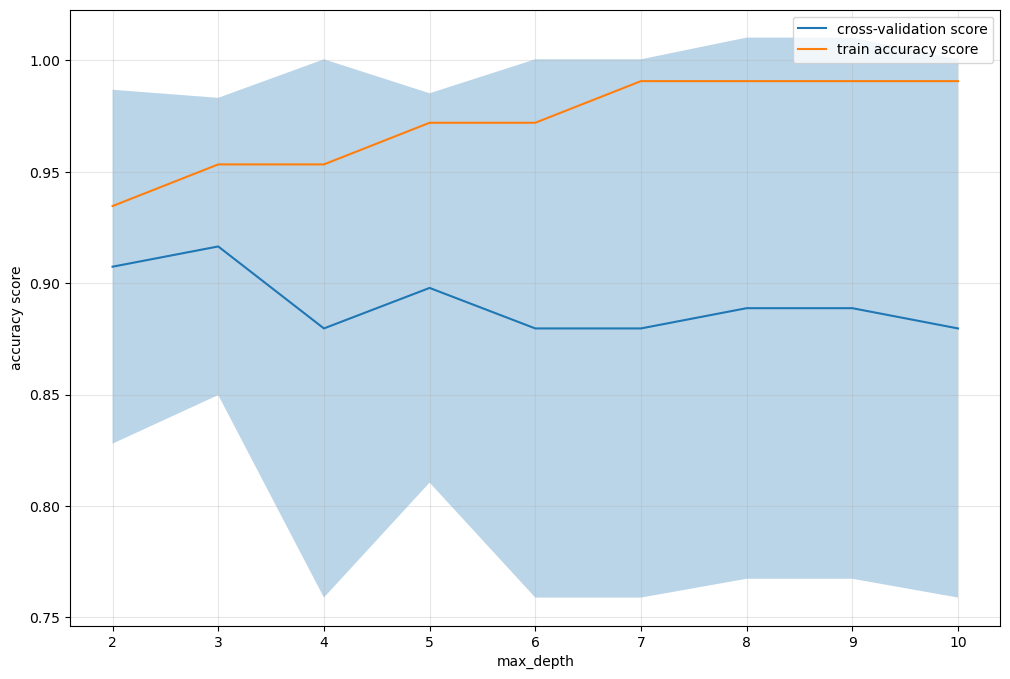

In [57]:
depth = np.arange(2,11,1)
train_score = []
cv_scores = []
cv_std = []
for i in depth:
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X, y)
    cv_tree = cross_val_score(tree, X, y, cv = 5)
    train_score.append(tree.score(X, y))
    cv_scores.append(np.mean(cv_tree))
    cv_std.append(np.std(cv_tree))

plt.figure(figsize = (12,8))
plt.grid(visible = True, alpha=0.3)
sns.lineplot(x = depth, y = cv_scores, label = "cross-validation score")
sns.lineplot(x = depth, y = train_score, label = "train accuracy score")
plt.fill_between(depth, np.asarray(cv_scores)-2*np.asarray(cv_std), np.asarray(cv_scores)+2*np.asarray(cv_std), alpha = 0.3)
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy score")

index = np.argmax(cv_scores)
print(f"with max_depth of {depth[index]} the model can achieve the best cross validation performance.")

In [52]:
# your code here
depths = list(range(2, 11))
train_scores = []
cv_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    train_scores.append(clf.score(X, y))
    cv_scores.append(cross_val_score(clf, X, y, cv=5))

In [53]:
# your code here
def plot_cv(ax, hyperparameter, cv_scores):
    cv_means = np.mean(cv_scores, axis=1)
    cv_stds = np.std(cv_scores, axis=1)
    handle, = ax.plot(hyperparameter, cv_means, '-*', label="Validation (mean)")
    plt.fill_between(hyperparameter, cv_means - 2.*cv_stds, cv_means + 2.*cv_stds, alpha=.3, color=handle.get_color())
    # !!!!!!!!!!!!

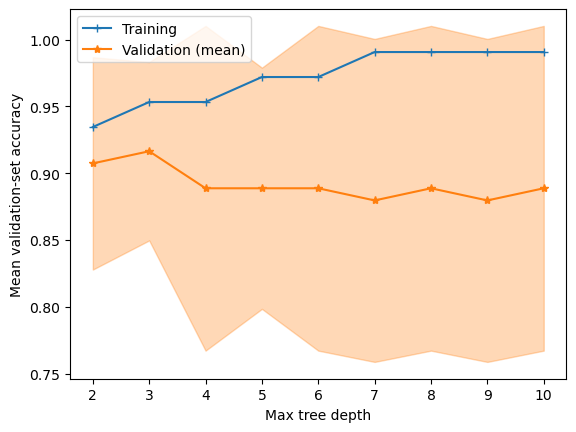

In [54]:
# your code here
fig, ax = plt.subplots()
ax.plot(depths, train_scores, '-+', label="Training")
plot_cv(ax, depths, cv_scores)
plt.xlabel("Max tree depth")
plt.ylabel("Mean validation-set accuracy")
plt.legend();

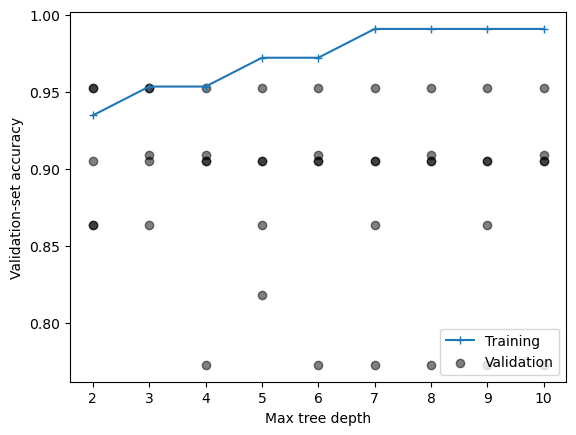

In [55]:
# Your code here
# Here's Kevin's suggested plot: since the loss is discrete and there are only 5 points per depth, just show them.
plt.plot(depths, train_scores, '-+', label="Training")
for i, (depth, scores) in enumerate(zip(depths, cv_scores)):
    plt.scatter(np.full(len(scores), depth), scores, color='k', alpha=.5, label="Validation" if i == 0 else None)
    # np.full Return a new array of given shape and type, filled with fill_value (depth)
    # !!!!!!!
plt.xlabel("Max tree depth")
plt.ylabel("Validation-set accuracy")
plt.legend(loc='lower right');


In [56]:
# your code here
cv_means = np.mean(cv_scores, axis=1)
best_depth = depths[np.argmax(cv_means)]
print(f"The best decision tree has maximum depth {best_depth}")

best_decision_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=0).fit(X, y)

The best decision tree has maximum depth 3


**your answer here**

Training accuracy hits nearly perfect at depth 7 and above. (It's not 1.0, maybe because there are two samples with identical predictors but different classes.)

We don't think that a depth-7 tree will generalize well, though: (1) it's overly complex; it's probably trying to pick apart the points in areas where the classes really do overlap, and (2) its validation-set performance (a quantitative estimate of how well it will generalize) is lower than smaller-depth trees.

`DecisionTreeClassifier` has some randomness in it, so depending on the random choices it made, depth 2 or depth 3 trees might come out with better validation performance. We'll choose depth 2 here.

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


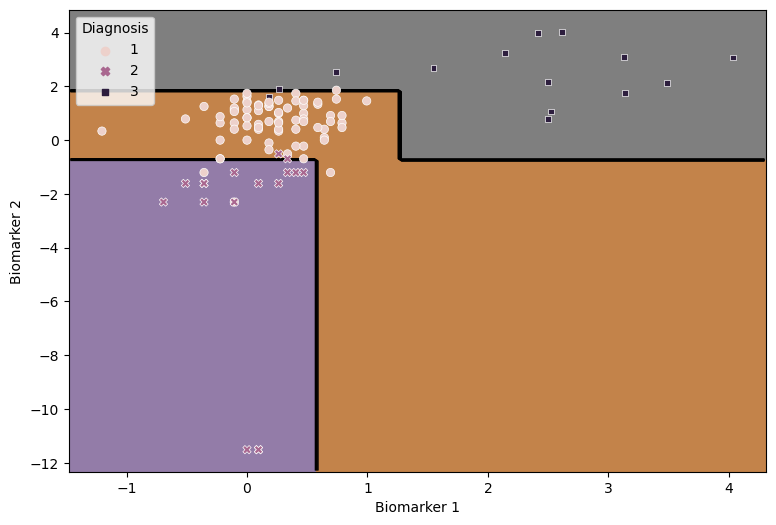

In [180]:
best_tree=DecisionTreeClassifier(max_depth=3).fit(train_x, train_y)
fig, ax = plt.subplots(figsize = (9,6))
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis", ax = ax)
overlay_decision_boundary(ax, best_tree)

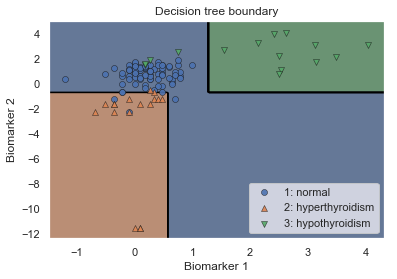

In [38]:
# your code here
plot_decision_boundary(X, y, best_decision_tree, 'Decision tree boundary', plt.gca())

**Your answer here**

All the boundary lines are axis-aligned, because each node in the decision tree depends on only a single feature. Other classifiers, even the linear ones, at least could have lines that were slanted relative to the axes.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

*Entirely optional note:* You can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, you can run GraphViz on your own computer, but you may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

[Text(0.5555555555555556, 0.875, 'x[1] <= -0.693\ngini = 0.464\nsamples = 107\nvalue = [75, 17, 15]'),
 Text(0.3333333333333333, 0.625, 'x[0] <= 0.582\ngini = 0.266\nsamples = 19\nvalue = [3, 16, 0]'),
 Text(0.2222222222222222, 0.375, 'x[0] <= -0.053\ngini = 0.198\nsamples = 18\nvalue = [2, 16, 0]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.346\nsamples = 9\nvalue = [2, 7, 0]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.0\nsamples = 9\nvalue = [0, 9, 0]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.7777777777777778, 0.625, 'x[0] <= 1.27\ngini = 0.301\nsamples = 88\nvalue = [72, 1, 15]'),
 Text(0.6666666666666666, 0.375, 'x[1] <= 1.879\ngini = 0.123\nsamples = 77\nvalue = [72, 1, 4]'),
 Text(0.5555555555555556, 0.125, 'gini = 0.078\nsamples = 75\nvalue = [72, 1, 2]'),
 Text(0.7777777777777778, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.0\nsamples = 11\nvalue = [0, 0, 11]')]

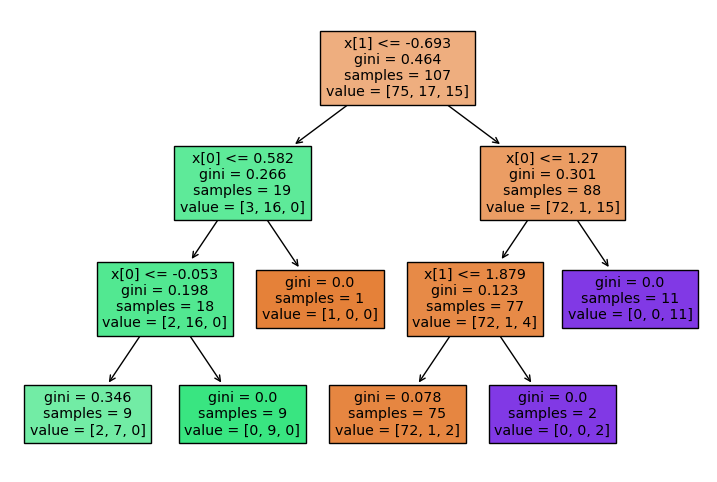

In [62]:
from sklearn import tree
plt.figure(figsize = (9,6))
tree.plot_tree(best_tree, filled= True)

In [181]:
tree = best_tree.tree_

n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold

In [187]:
tree.value

array([[[75., 17., 15.]],

       [[ 3., 16.,  0.]],

       [[ 2., 16.,  0.]],

       [[ 2.,  7.,  0.]],

       [[ 0.,  9.,  0.]],

       [[ 1.,  0.,  0.]],

       [[72.,  1., 15.]],

       [[72.,  1.,  4.]],

       [[72.,  1.,  2.]],

       [[ 0.,  0.,  2.]],

       [[ 0.,  0., 11.]]])

In [182]:
feature
# feature used for splitting node i
# -2 means leaves, not splitting

array([ 1,  0,  0, -2, -2, -2,  0,  1, -2, -2, -2], dtype=int64)

In [184]:
children_left
#  id of the left child of node i or -1 if leaf node

array([ 1,  2,  3, -1, -1, -1,  7,  8, -1, -1, -1], dtype=int64)

In [63]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [64]:
# your code here
show_tree_structure(best_decision_tree)
print("\nReminder: the class names were:", class_names)

The binary tree structure has 11 nodes:

node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2
      node 4: predict class 2
    node 5: predict class 1
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1
      node 9: predict class 3
    node 10: predict class 3

Reminder: the class names were: {1: '1: normal', 2: '2: hyperthyroidism', 3: '3: hypothyroidism'}


In [188]:
# your code here
if False:
    export_graphviz(best_decision_tree, out_file='tree_viz.dot')

**Your answer here**

hypothyroidism is class 3. Our decision tree only predicts class 3 in node 6. We get to node 6 by
- root: x1 > -.693
- node 4: x0 > 1.27

The leaf criterion is the logical AND of every criterion on the way. So we predict hypothyroidism if Biomarker 1 > 1.27 and Biomarker 2 > -.693. 

If we got unlucky and ended up with a depth-3 or greater tree coming out best in the CV, the result looks more complicated. e.g., for one such tree (`random_state=3` in the CV) we get 

`
node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2
      node 4: predict class 2
    node 5: predict class 1
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1
      node 9: predict class 3
    node 10: predict class 3
`

For this, we predict class 3 in nodes 9 or 10. Both are under node 6, which we get to if x1 > -.693. But then there's a branch, so we need a logical OR between two conditions:
- (node 10) x1 > -.693 and x0 > 1.270
- (node 9) x1 > -.693 and x0 <= 1.270 and x1 > 1.879, or simplified, x1 > 1.879 and x0 <= 1.270

So we'd predict hypothyroidism if Biomarker 1 > 1.270, or if Biomarker 1 < 1.270 and Biomarker 2 > 1.879.


<div class='exercise'><b> Question 5 [18 pts]: k-NN and Model comparison </b> </div>

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.

**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*

In [66]:
k_n = np.arange(1,21,1)
knn_scores = []
for i in k_n:
    knn = KNeighborsClassifier(n_neighbors=i).fit(train_x, train_y)
    knn_score = cross_val_score(knn, train_x, train_y, cv = 5)
    knn_scores.append(np.mean(knn_score))

knn_index = np.argmax(knn_scores)
print(f"the best k is {k_n[knn_index]}.")

the best k is 4.


In [42]:
# your code here
k_vals = list(range(1, 20))
train_scores = [KNeighborsClassifier(n_neighbors=k).fit(X, y).score(X, y) for k in k_vals]
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X, y, cv=5) for k in k_vals]

Best k: 4


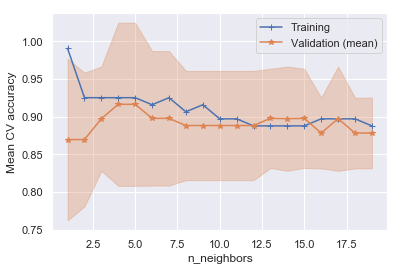

In [43]:
# your code here
fig, ax = plt.subplots()
ax.plot(k_vals, train_scores, '-+', label="Training")
plot_cv(ax, k_vals, cv_scores)
plt.xlabel("n_neighbors")
plt.ylabel("Mean CV accuracy");
plt.legend()

best_k = k_vals[np.argmax(np.mean(cv_scores, axis=1))]
print("Best k:", best_k)

best_knn_clf = KNeighborsClassifier(n_neighbors=best_k).fit(X, y)

# KCA: those estimates have huge variance. It would be great if our dataset were bigger! But at least students might notice this and be less confident about the super-wiggly low-k model.

As an aside, let's try standardizing before kNN. This will affect the distance metric that kNN uses.

In [67]:
knn_scores2 = []
for i in k_n:
    knn_pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=i)
    ).fit(train_x, train_y)
    knn_scores2.append(np.mean(cross_val_score(knn_pipeline, train_x, train_y, cv = 5)))

knn_index = np.argmax(knn_scores2)
print(f"the best k is {k_n[knn_index]}.")

the best k is 3.


In [44]:
# your code here
def make_standardized_knn(n_neighbors):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=n_neighbors))
train_scores_standardized = [make_standardized_knn(k).fit(X, y).score(X, y) for k in k_vals]
cv_scores_standardized = [cross_val_score(make_standardized_knn(n_neighbors=k), X, y, cv=5) for k in k_vals]

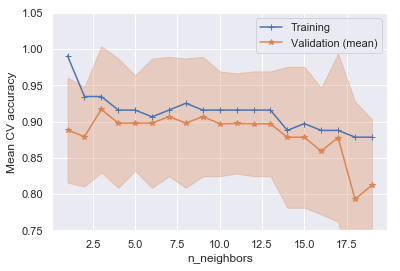

In [45]:
# your code here
fig, ax = plt.subplots()
ax.plot(k_vals, train_scores_standardized, '-+', label="Training")
plot_cv(ax, k_vals, cv_scores_standardized)
plt.xlabel("n_neighbors")
plt.ylabel("Mean CV accuracy");
plt.ylim([.75, 1.05])
plt.legend();

In [46]:
print("Best without standardizing: {:.3%}, best with standardizing: {:.3%}".format(
    np.max(np.mean(cv_scores, axis=1)),
    np.max(np.mean(cv_scores, axis=1))))

Best without standardizing: 91.645%, best with standardizing: 91.645%


It may not be really worth it to standardize: we get the same peak accuracy, but that's just for one magic k-value (see the graph). We'll proceed without standardizing.

**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Logistic regression with quadratic and interaction terms; QDA.
- k-NN and whichever other model has the most complex decision boundaries

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


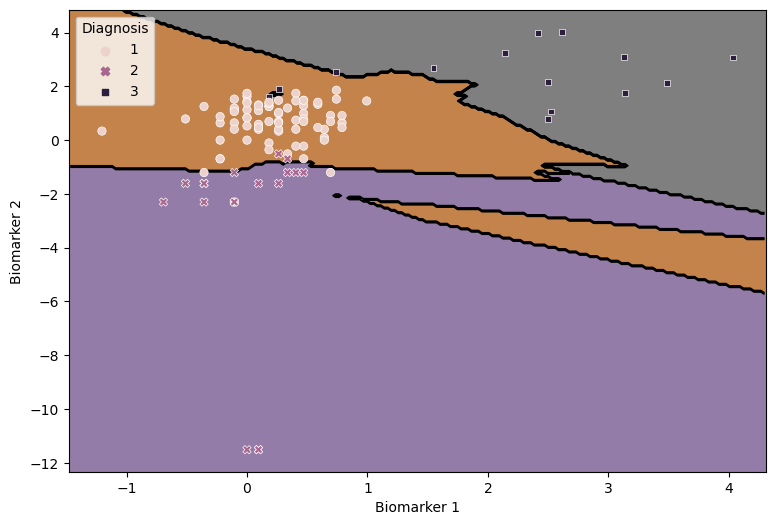

In [69]:
best_knn = KNeighborsClassifier(n_neighbors=4).fit(train_x, train_y)

fig, ax = plt.subplots(figsize = (9,6))
sns.scatterplot(data = data_train, x = "Biomarker 1", y = "Biomarker 2", hue = "Diagnosis", style = "Diagnosis", ax = ax)
overlay_decision_boundary(ax, best_knn)

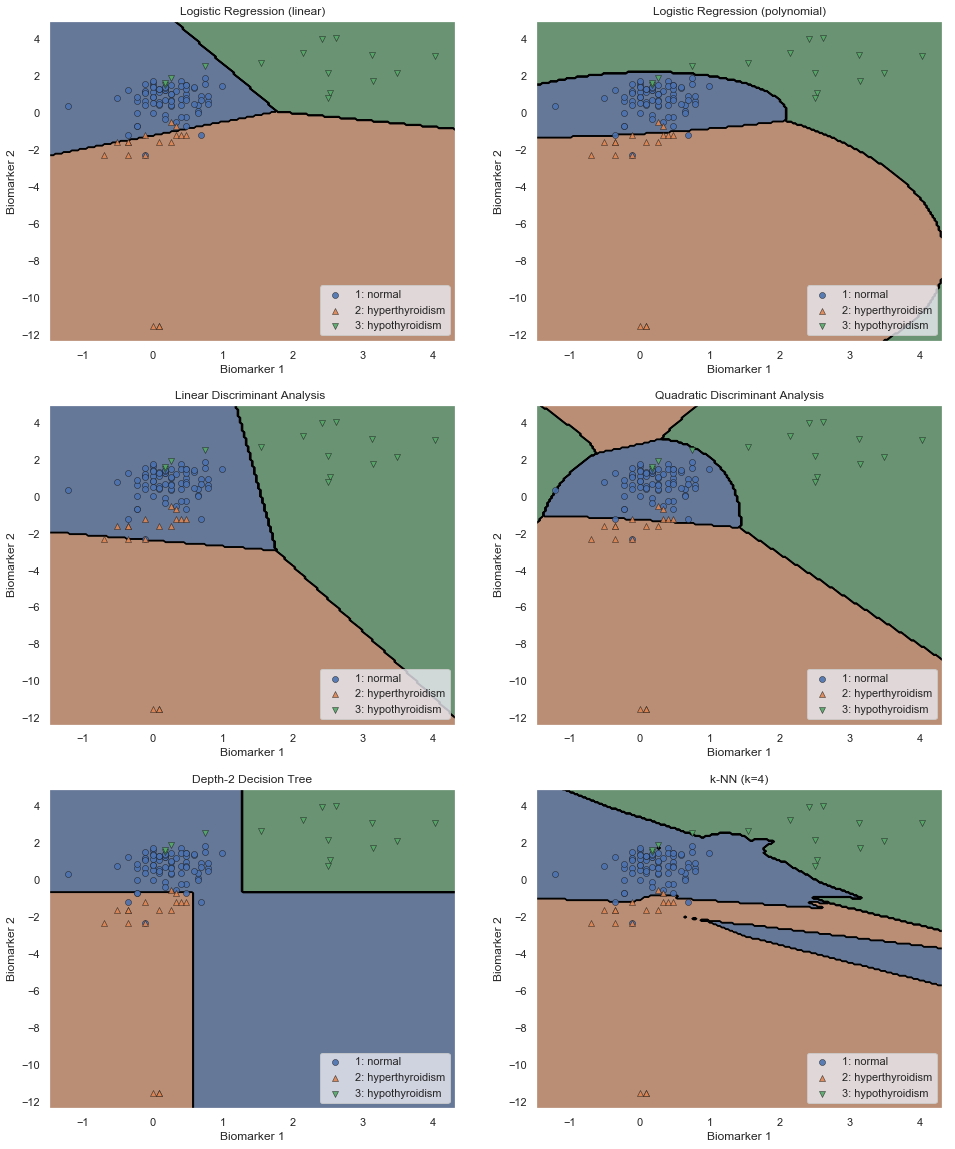

In [47]:
# Your code here
named_classifiers = [
    ("Logistic Regression (linear)", logreg_ovr),
    ("Logistic Regression (polynomial)", polynomial_logreg_estimator),
    ("Linear Discriminant Analysis ", lda),
    ("Quadratic Discriminant Analysis", qda),
    (f"Depth-{best_depth} Decision Tree", best_decision_tree),
    (f"k-NN (k={best_k})", best_knn_clf),
]
fig, axs = plt.subplots(3, 2, figsize=(16, 20))
for ax, (name, clf) in zip(axs.flatten(), named_classifiers):
    plot_decision_boundary(X, y, clf, name, ax)

**your answer here**

* Both the linear logistic regression model and LDA have straight lines as decision boundaries. When looking at the boundaries for the LDA model, you can see that it is keeping the same covariance over each grouping of points, which in some cases is creating some error (e.g. the boundary separating Normal and Hyperthyroidism). As LDA is keeping the covariances the same, we can see that some of the regions, namely the Normal region in the middle, is being kept wider than it otherwise may be. That region is more narrow in the logistic regression model.

* The quadratic logistic regression and the QDA models both fit curved boundaries, but logistic regression only gives a single contiguous region to each of the classes, while QDA gives multiple regions for the two rarer classes: QDA is creating a distributional 'ring' around each grouping of points.

* k-NN has the most complex decision boundaries. In some cases they do seem to be motivated by the data, e.g., the nuanced delineation between normal and both other classes, but the other boundaries seem arbitrary, like the extra region for Normal in the middle of the Hyper region, and likely indicate overfitting.

**5.3** Describe how each *type* of model classifies an observation from the test set in one short sentence for each (assume that the model is already fit, but not necessarily to this current dataset). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest-Neighbors Classifier
- Decision Tree

**Your answer here**

- **One-vs-Rest Logistic Regression** computes the prob of the observation being in each class, then normalizes the probs to sum to 1. Each prob is computed as sigmoid of the dot product of the feature vector and the class coefficients.
- **Quadratic Discriminant Analysis** computes the likelihood of observing the sample under a Normal distribution with mean and covariance estimated from the data in each class, and assigns the sample to the class that gives it the highest likelihood.
- **Linear Discriminant Analysis** works the same as QDA, but the covariance matrics are the same for each class (it pools the data from all classes to estimate the covariance).
- **k-Nearest-Neighbors Classifier** assigns each sample to the most common class among the $k$ samples in the training set that are nearest to it (using some distance metric, usually Euclidean).
- **Decision Tree** traverses a tree; each non-leaf node contains a rule of the form "if feature X exceeds T, go right, otherwise go left". The leaves say "predict class Y".

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

In [48]:
# your code here
cv_scores = [
    cross_val_score(clf, X, y, cv=5, n_jobs=-1)
    for name, clf in named_classifiers
]

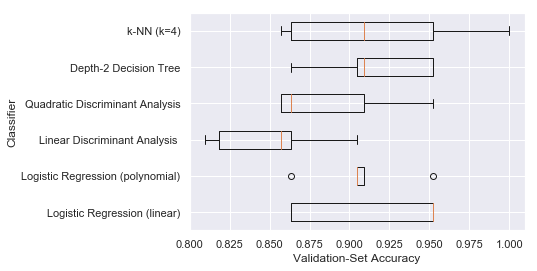

In [49]:
# your code here
# TODO: replace with simpler graph
positions = np.arange(len(named_classifiers))
plt.boxplot(cv_scores, vert=False, positions=positions);
plt.yticks(positions, [name for name, model in named_classifiers])
plt.ylabel("Classifier")
plt.xlabel("Validation-Set Accuracy");

In [50]:
# your code here
performance_estimates = pd.DataFrame([
    [scores.mean(), scores.std()] for scores in cv_scores
], index=[name for name, model in named_classifiers], columns=["mean", "std"])

performance_estimates.sort_values('mean')

,mean,std
Linear Discriminant Analysis,0.850649,0.034306
Quadratic Discriminant Analysis,0.887879,0.037650
Logistic Regression (polynomial),0.906926,0.028122
k-NN (k=4),0.916450,0.054097
Depth-2 Decision Tree,0.916450,0.033353
Logistic Regression (linear),0.916883,0.043476


**Your answer here**

The CV scores of linear logreg, DT, and kNN are very similar. Only LDA looks consistently worse.

**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

In [51]:
# your code here
X_test = data_test.iloc[:,:-1].values
y_test = data_test.iloc[:,-1].values
performance_estimates.assign(test_accuracy=[
        accuracy_score(y_test, clf.predict(X_test))
        for name, clf in named_classifiers]).sort_values('test_accuracy')

,mean,std,test_accuracy
Linear Discriminant Analysis,0.850649,0.034306,0.814815
Logistic Regression (linear),0.916883,0.043476,0.842593
Quadratic Discriminant Analysis,0.887879,0.037650,0.851852
k-NN (k=4),0.916450,0.054097,0.851852
Logistic Regression (polynomial),0.906926,0.028122,0.861111
Depth-2 Decision Tree,0.916450,0.033353,0.870370


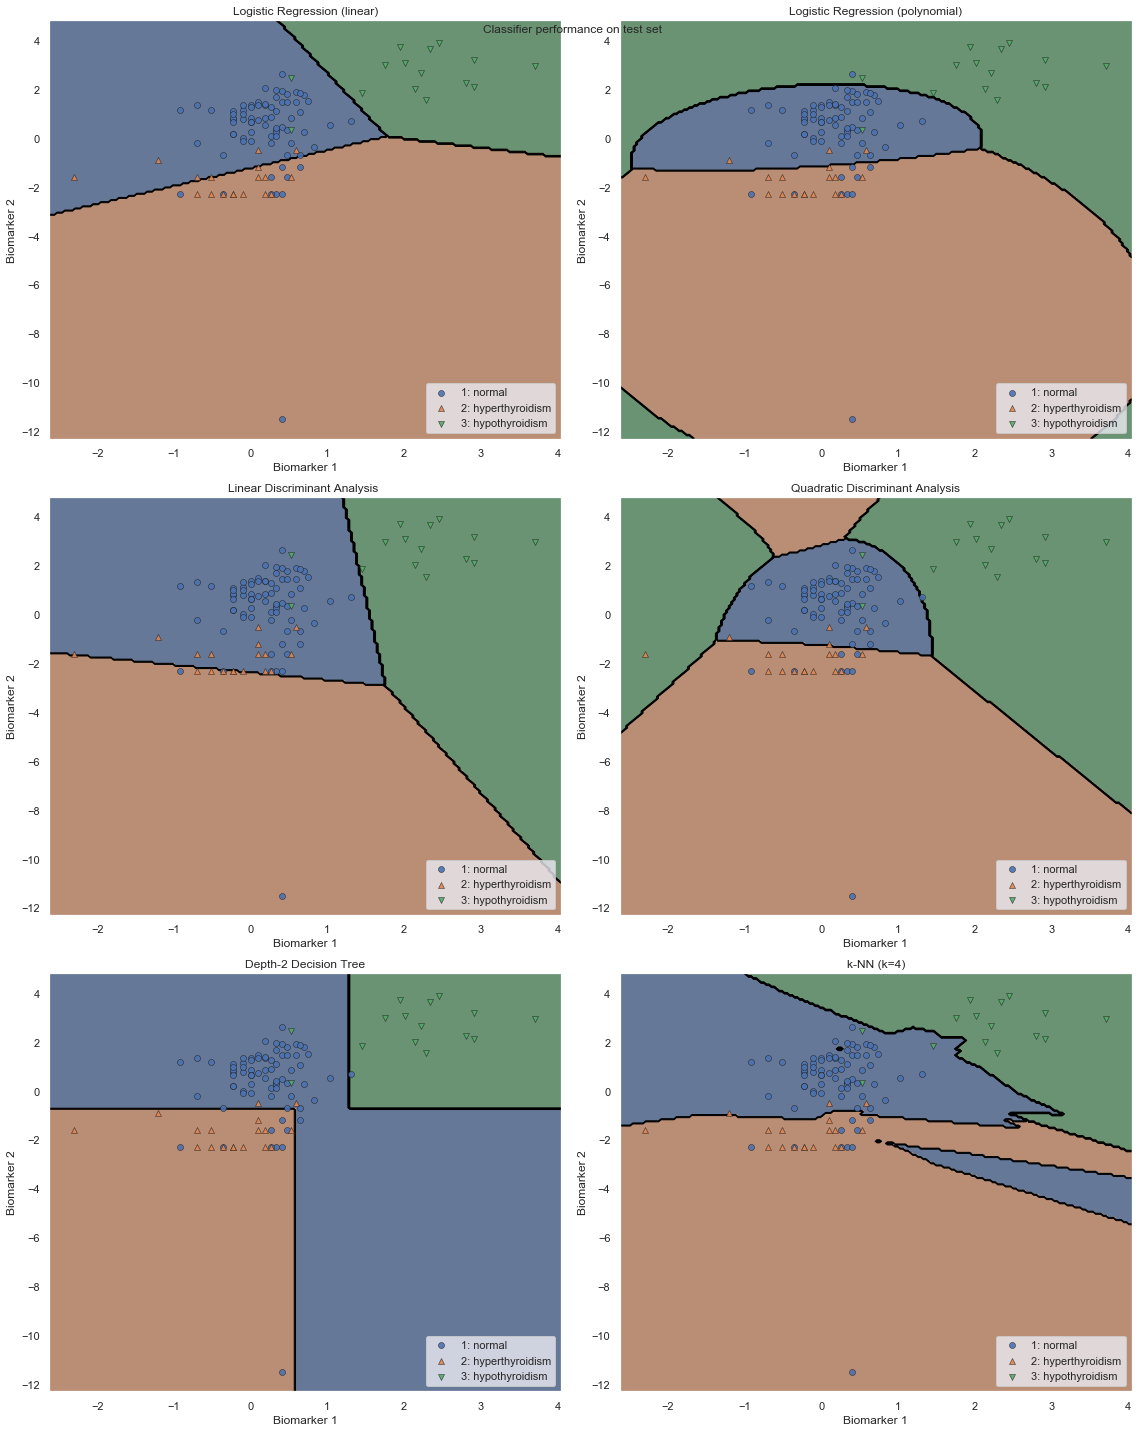

In [52]:
# your code here
fig, axs = plt.subplots(3, 2, figsize=(16, 20))
for ax, (name, clf) in zip(axs.flatten(), named_classifiers):
    plot_decision_boundary(X_test, y_test, clf, name, ax)
fig.suptitle("Classifier performance on test set")
fig.tight_layout()

**your answer here**

I'd favor linear logistic regression, since it's simple and performs well in cross-validation estimates. However, the differences between the models are almost all within the noise of the CV estimates, so I'm not too surprised to see that polynomial logistic regression worked best in this particular test set. I tried a different random seed and indeed the order changed (e.g., kNN did best, then Decision Trees, probably because the CV chose a lower tree depth.)

**5.6**. Compare and contrast the six models based on each of the following criteria:
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**your answer here**

- Classification performance: They were all quite similar, except for LDA (which misclassified the disease classes as Normal, as we saw earlier.

- Complexity of decision boundary: the decision tree seems too simple -- all the decisions are axis-aligned, but probably a diagonal cut would work better. (We didn't try a decision tree on polynomial features, that would be interesting). On the other hand, kNN seems to make boundaries that are far more complicated than is really going on -- do we really believe that there's this tiny sliver of Normal that's surrounded by Hyperthyroidism on all sides? The logistic regression boundaries seem to make most sense, both the linear and polynomial.

- Memory storage: k-NN requires storing the entire training set to make a prediction... not bad at all when we only have a few hundred samples like here, but for bigger datasets that's going to hurt badly. The linear logistic regression is the opposite extreme: for $k$ predictors, we only need to store $k+1$ coefficients for each of the 3 classes, regardless of how much data we have. QDA requires $k$ means and $k*(k-1)$ covariances, for each class, so more memory required. The decision tree could be very shallow (small!) or deep (big!) depending on the data and max depth.

- Interpretability: Decision tree is the clear winner for our task: a clinician can easily walk through the decision-making process and see if it makes sense. But if the tree was deeper, it would become much harder to interpret. k-NN is, in a sense, easier to explain what's going on (just choose the class of the $k$ most similar patients we've seen before). LDA and QDA have a straightforward model of the data that you can visualize and see if it makes sense. Logistic regression, especially polynomial, seems the hardest to explain and understand.

As a clinician, I'd want a decision rule that performs well (ruling out LDA) and is easy to understand (ruling out logistic regression). It should also make biological sense, so I'd probably rule out k-NN and QDA because their decision boundaries have those arbitrary regions. So I think I'd choose the decision tree here.

<div class='exercise'><b> Question 6: [2 pts] Including an 'abstain' option </b></div>
**Note this question is only worth 2 pts. **

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is 5000 dollars, and the cost incurred when the model abstains from making a prediction is 1000 dollars. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

In [166]:
def cost_fun(prediction, true_val):
    cost = 0
    cost += np.sum(prediction == 0)*1000
    t_prediction = prediction[prediction != 0]
    t_val = true_val[prediction != 0]
    cost += np.sum(t_prediction != t_val) *5000
    return cost
prediction = polynomial_logreg_estimator.predict(test_x)
print(f"the cost is {cost_fun(prediction, test_y)/len(test_y)}.")

the cost is 787.0370370370371.


In [168]:
prediction = []
probs = polynomial_logreg_estimator.predict_proba(test_x)
for prob, val in zip(probs, test_y):
    if 5000*(1-prob[val-1])>1000:
        # 1-max(prob)
        prediction.append(0)
    else:
        prediction.append(np.argmax(prob)+1)

prediction = np.asarray(prediction)
print(f"the cost is {cost_fun(prediction, test_y)/len(test_y)}.")

the cost is 407.4074074074074.


**Your answer here**

**General approach**: Assuming the OvR logistic regression model, we estimate $p_j$ for $j\in \{1,2,3\}$, the marginal probability of being in each class, and then normalize these to sum to 1 (handled by sklearn). The normalization step is not necessary for the multinomial model, since the softmax function is already constrained to sum to 1. 

Following the hint, we will proceed by using the trained OvR logistic regression model to estimate $\hat{p}_j$ and then making a decision based on minimizing the expected cost. The expected cost for abstaining is \$1000. The expected cost for predicting is \$ $5000 * P(\text{misdiagnosis}) = 5000 * (1 - \hat{p}_k)$ where $k$ is the label of the predicted class. 

So our decision rule is if $5000 * (1 - \hat{p}_k) < 1000$, attempt a prediction. Otherwise, abstain.


**6.1**

In [172]:
# your code here
#we will take the convention that 0 is the abstain option

def cost(decisions, val):
    
    #number of times abstained
    cost = 1000 * len(decisions[decisions == 0])
    true_vals = val[decisions != 0]
    predicted_vals = decisions[decisions !=0]
    
    #number of incorrect predictions
    cost += 5000* sum(true_vals != predicted_vals)
    return(cost)


#for the first part of the question the decisions are just the predictions

dec = logreg_ovr.predict(data_test.iloc[:,:-1].values) 
vl = data_test.iloc[:,-1].values
print("Cost incurred for OvR Logistic Regression Model: $", cost(dec,vl)/len(vl))

Cost incurred for OvR Logistic Regression Model: $ 787.0370370370371


**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.



In [173]:
# your code here
#new decision rule, for the second part of the problem 
def decision_rule(lrm_mod,input_data):
    probs = lrm_mod.predict_proba(input_data)
    predicted_class = np.argmax(probs,axis = 1) + 1
    conf = 1.0 - np.max(probs,axis = 1)
    predicted_class[5000*conf > 1000.0] = 0
    return(predicted_class)

dec2 = decision_rule(logreg_ovr,data_test.iloc[:,:-1].values)
print("Cost incurred for new model: $", cost(dec2,vl)/len(vl))

Cost incurred for new model: $ 638.8888888888889
